In [95]:
import numpy as np
import pandas as pd
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
from sklearn.metrics import accuracy_score, precision_score

def train(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    print(f"{name} - accuracy: {accuracy:.2f} -- precision: {precision:.2f}")

In [97]:
ps = PorterStemmer()

def transformText(text):
    text  = text.lower()
    text = nltk.word_tokenize(text)

    y = []

    for i in text:
        if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation:
            y.append(ps.stem(i))

    return " ".join(y)

transformText('Then go to the village pump and suggest they change the language in how a RFC should be set up.')

'go villag pump suggest chang languag rfc set'

In [114]:
df = pd.read_csv('./dataset/clean_data.csv').head(1000)
df['transformed_text'] = df['text'].apply(transformText)
df.rename(columns={"is_profane": 'target', 'transformed_text': 'content'}, inplace=True)
# df.drop(columns='text', inplace=True)

In [99]:
df.head()

,target,content
0,0,go villag pump suggest chang languag rfc set
1,1,anti greek nationali hi alexikoua you vandalis...
2,1,di hoe wasnt di violent lotteri ticket
3,0,better atabay help ban vandal push pov
4,0,camelcas sicko camelcas camelcas rule baley me...


In [100]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   1000 non-null   int64 
 1   content  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


(1000, 2)

In [101]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

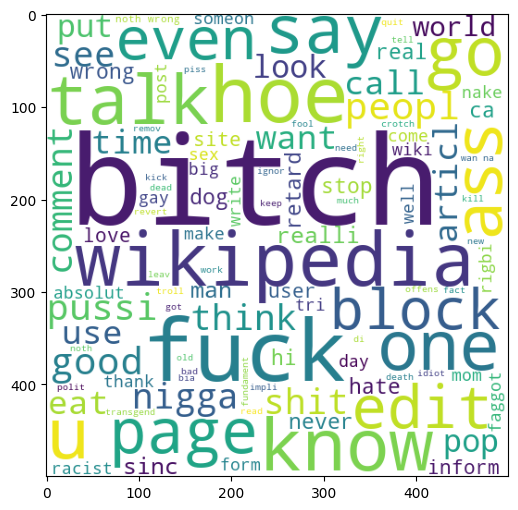

In [108]:
wctest = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
profane_text = wctest.generate(df[df['target'] == 1]['text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(profane_text)
plt.show()

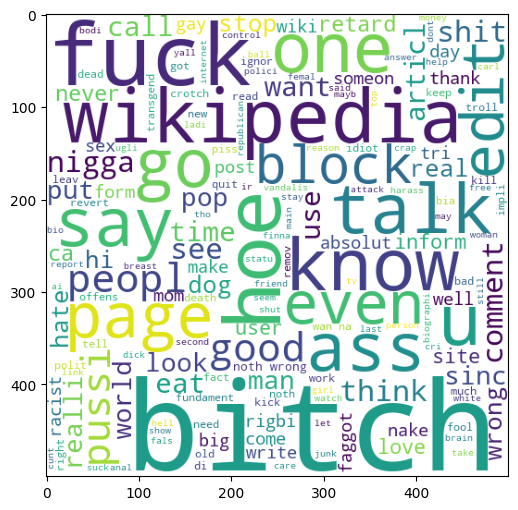

In [109]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
profane_wc = wc.generate(df[df['target'] == 1]['content'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(profane_wc)
plt.show()

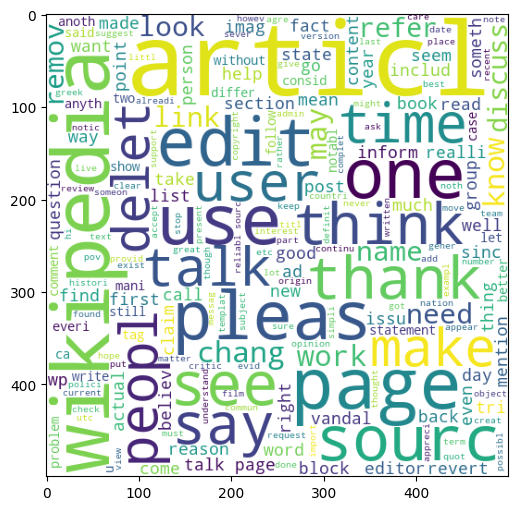

In [110]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
sane_wc = wc.generate(df[df['target'] == 0]['content'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(sane_wc)
plt.show()

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,5))
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)

X = df['content']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()


In [112]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

classers = {
    'nb': MultinomialNB(),
    'rfc': RandomForestClassifier(n_estimators=50, random_state=2),
    'knn': KNeighborsClassifier(),
    'hard-vote': VotingClassifier(
        estimators=[
            ('nb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('knn', KNeighborsClassifier())
        ],
        voting='hard'
    ),
    'soft-vote': VotingClassifier(
        estimators=[
            ('nb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('knn', KNeighborsClassifier())
        ],
        voting='soft'
    )
}

for name, model in classers.items():
    train(name, model, X_train, y_train, X_test, y_test)

nb - accuracy: 0.93 -- precision: 0.94
rfc - accuracy: 0.94 -- precision: 0.85
knn - accuracy: 0.90 -- precision: 0.86
hard-vote - accuracy: 0.94 -- precision: 0.95
soft-vote - accuracy: 0.94 -- precision: 0.95


In [113]:
def test(text):
    txt = tfidf.transform([text])
    print("="*40)
    for name, clf in classers.items():
        prediction = clf.predict(txt)
        # print(prediction)
        prediction = 'not-profane' if prediction == 0 else 'profane'
        print(f"{name} thinks '{text}' -> {prediction}")
        
testData = ["Hi Bruv, Hope you are doing well", "Love this product", "She's a hoe", "She's a whore", 'Suck water from bottle', "write the article ibtch", "Idiot, A cup of cum for you! DRINK IT ALL PLZ", "A cup of cum for you! DRINK IT ALL PLZ"]

for text in testData:
    test(text)

nb thinks 'Hi Bruv, Hope you are doing well' -> not-profane
rfc thinks 'Hi Bruv, Hope you are doing well' -> not-profane
knn thinks 'Hi Bruv, Hope you are doing well' -> not-profane
hard-vote thinks 'Hi Bruv, Hope you are doing well' -> not-profane
soft-vote thinks 'Hi Bruv, Hope you are doing well' -> not-profane
nb thinks 'Love this product' -> not-profane
rfc thinks 'Love this product' -> not-profane
knn thinks 'Love this product' -> not-profane
hard-vote thinks 'Love this product' -> not-profane
soft-vote thinks 'Love this product' -> not-profane
nb thinks 'She's a hoe' -> profane
rfc thinks 'She's a hoe' -> profane
knn thinks 'She's a hoe' -> profane
hard-vote thinks 'She's a hoe' -> profane
soft-vote thinks 'She's a hoe' -> profane
nb thinks 'She's a whore' -> not-profane
rfc thinks 'She's a whore' -> not-profane
knn thinks 'She's a whore' -> profane
hard-vote thinks 'She's a whore' -> not-profane
soft-vote thinks 'She's a whore' -> not-profane
nb thinks 'Suck water from bottle' 